In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [2]:
train = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
print(test['keyword'].isna().sum())

26



We have 10,000 rows of data, containing a text feature - the text of a tweet. We also have keyword and location features. Our aim is to use the text features to predict if the tweet is describing a disaster, or not - binary classification problem. 

We have approximately 7600 rows of training data and 3200 rows of test data. We'll have to engineer the text features into numerical features useable for a neural network.


Immediately, it's evident that a lot of the rows have null values for the Location and Keyword features. We should take a closer look, to see if these features are useable. 

In [3]:
print('Train Location NaN = ', train['location'].isna().sum())
print('Train Keyword NaN = ', train['keyword'].isna().sum())
print(train['keyword'].value_counts())
print(test['keyword'].value_counts())
print(train['location'].value_counts())

Train Location NaN =  2533
Train Keyword NaN =  61
keyword
fatalities               45
deluge                   42
armageddon               42
sinking                  41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: count, Length: 221, dtype: int64
keyword
deluged               23
demolished            22
rubble                22
first%20responders    21
seismic               21
                      ..
threat                 5
fatalities             5
forest%20fire          5
inundation             4
epicentre              1
Name: count, Length: 221, dtype: int64
location
USA                    104
New York                71
United States           50
London                  45
Canada                  29
                      ... 
MontrÌ©al, QuÌ©bec       1
Montreal                 1
ÌÏT: 6.4682,3.18287      1
Live4Heed??         

In our training data, roughly a third of the data is null with respect to Location. Given that we are dealing with a small dataset as it is, we will drop the location feature.

In [4]:
train = train.drop('location', axis = 1)
test = test.drop('location', axis = 1)

We'll remove stopwords from our dataset.

In [5]:
import nltk
from nltk.corpus import stopwords


nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word.lower() not in stop_words])


train['text'] = train['text'].apply(remove_stopwords)
test['text'] = test['text'].apply(remove_stopwords)


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


The keyword feature is interesting, and may be too sparse (too many different keywords) to be of great use to us. We will factor it in a little later.

Next, we need to convert our text data to numerical features. Tensorflow has functionality to create a Text Vectorization layer, which will map each word in text to a token index. After enough learning with our model, words with a similar meaning should end up represented by a similar vector. 



We can use the keras.Sequential method, with the above encoder passed as the initial layer. We'll prepare our dataframe to train the model, and get prepare some visualizations to hopefully get some insights about the data. We'll be creating a text vectorization layer that will learn the vocabulary, and convert each word it learns into a vector.

In [6]:
train_new = train[['text','target']]
test_new = test[['text']]


X_train = np.array(train_new['text']) 
y_train = np.array(train_new['target']) 


train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.batch(32)


X_test = np.array(test_new['text'])
test_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_dataset = test_dataset.batch(32)

encoder = tf.keras.layers.TextVectorization(max_tokens=10000)

encoder.adapt(train['text'].values)

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

vocab = encoder.get_vocabulary()



            word  frequency
19         [UNK]      12670
127         like        345
56            im        299
297          amp        298
9           fire        250
...          ...        ...
3414        xela          1
3407       tonne          1
7400         rnk          1
7401  rockingham          1
9999    symptoms          1

[9999 rows x 2 columns]


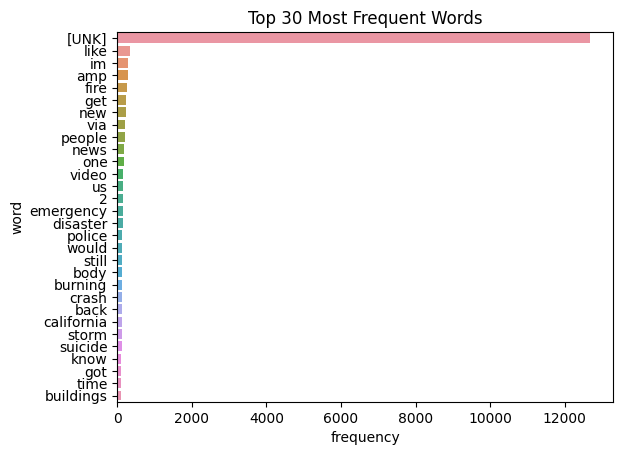

In [8]:
from collections import Counter

tokenized_data = encoder(train_new['text']).numpy()

word_indices = np.ravel(tokenized_data)
word_counts = Counter(word_indices)

vocab = encoder.get_vocabulary()
word_freq = {vocab[idx]: count for idx, count in word_counts.items()}
word_freq_df = pd.DataFrame(list(word_freq.items()), columns=['word', 'frequency']).sort_values(by='frequency', ascending=False)
word_freq_df = word_freq_df[word_freq_df['word'].str.strip() != '']
print(word_freq_df)

top_words = word_freq_df.head(30)
sns.barplot(x='frequency', y='word', data=top_words)
plt.title('Top 30 Most Frequent Words')
plt.show()

UNK represents words that are unknown by the dataset. And, we can see the remaining top 29 words. We started with a vocabulary size of 5000 words, but we will tweak this as well.

Below is a histogram of word frequencies. For readability, we have frequency bins on the x-axis, and the number of words fitting into the respective bins on the y-axis.



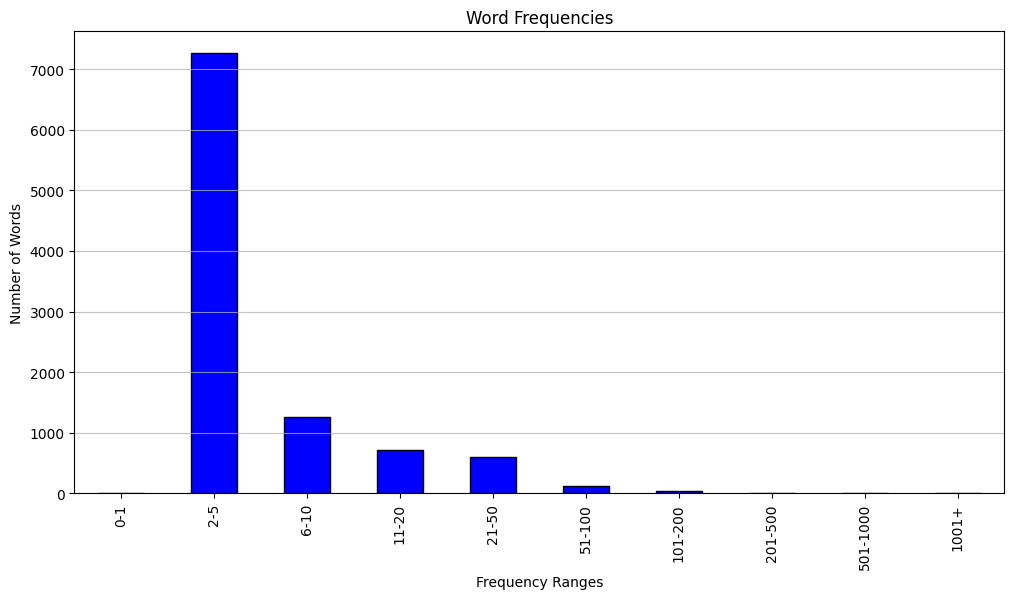

In [9]:
word_freq_df['frequency'] = pd.to_numeric(word_freq_df['frequency'], errors='coerce')

word_freq_df = word_freq_df.dropna(subset=['frequency'])

bins = [0, 1, 5, 10, 20, 50, 100, 200, 500, 1000, 5000]
labels = ['0-1', '2-5', '6-10', '11-20', '21-50', '51-100', '101-200', '201-500', '501-1000', '1001+']

word_freq_df['frequency_binned'] = pd.cut(word_freq_df['frequency'], bins=bins, labels=labels, right=False)

binned_counts = word_freq_df['frequency_binned'].value_counts().sort_index()


plt.figure(figsize=(12, 6))
binned_counts.plot(kind='bar', color='blue', edgecolor='black')
plt.title('Word Frequencies')
plt.xlabel('Frequency Ranges')
plt.ylabel('Number of Words')
plt.grid(axis='y', alpha=0.75)
plt.show()

Our word data is qite sparse. Almost half of our learned vocabulary occurs within 2-5 times in the entire dataset. This is one of the challenges associated with having quite a small dataset (10,000 samples total). We will do the best we can.

In [10]:



model = tf.keras.Sequential([
    tf.keras.Input(shape=(1,),dtype=tf.string),
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),  
        output_dim=64,
        mask_zero=True  
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)  
])


model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])


In [11]:



history = model.fit(train_dataset, epochs=10)
pred = model.predict(X_test)

predictions = tf.nn.sigmoid(pred).numpy()

binary_predictions = np.where(predictions >= 0.5, 1, 0)



Epoch 1/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.5968 - loss: 0.6897
Epoch 2/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.5979 - loss: 0.6584
Epoch 3/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.7989 - loss: 0.4550
Epoch 4/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.8712 - loss: 0.3281
Epoch 5/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9035 - loss: 0.2591
Epoch 6/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9232 - loss: 0.2062
Epoch 7/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9371 - loss: 0.1815
Epoch 8/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9416 - loss: 0.1549
Epoch 9/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.9529 - loss: 0.1408
Epoch 10/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9608 - loss: 0.1156
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step


In [12]:

ids = test['id']

output_df = pd.DataFrame({
    'id':ids,
    'target': binary_predictions.flatten() 
})
output_file_path = '/kaggle/working/submissionA.csv'
output_df.to_csv(output_file_path, index=False)


For the record, this approach gave us accuracy of 77% on the test data. Can we do better?

We'll try experimenting with the vocabulary size, learning rate and a couple of different architectural ideas. First, we'll try increasing the learning rate from 0.0001 to 0.001

In [13]:
encoder = tf.keras.layers.TextVectorization(max_tokens=5000)

encoder.adapt(train['text'].values)

model = tf.keras.Sequential([
    tf.keras.Input(shape=(1,),dtype=tf.string),
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),  
        output_dim=64,
        mask_zero=True  
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1) 
])

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

history = model.fit(train_dataset, epochs=10)
pred = model.predict(X_test)

predictions = tf.nn.sigmoid(pred).numpy()

binary_predictions = np.where(predictions >= 0.5, 1, 0)

ids = test['id']

output_df = pd.DataFrame({
    'id':ids,
    'target': binary_predictions.flatten()
})
output_file_path = '/kaggle/working/submissionB.csv'
output_df.to_csv(output_file_path, index=False)

Epoch 1/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.6128 - loss: 0.6761
Epoch 2/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.8304 - loss: 0.4076
Epoch 3/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.8858 - loss: 0.2882
Epoch 4/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.9077 - loss: 0.2403
Epoch 5/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.9345 - loss: 0.1701
Epoch 6/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.9543 - loss: 0.1249
Epoch 7/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.9595 - loss: 0.1069
Epoch 8/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.9688 - loss: 0.0760
Epoch 9/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.9761 - loss: 0.0616
Epoch 10/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.9766 - loss: 0.0484
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step


Let's try increasing the vocabulary from a maximum size of 5000, to a maximum size of 10000. Maintaining the same learning rate.

In [14]:
encoder = tf.keras.layers.TextVectorization(max_tokens=10000)

encoder.adapt(train['text'].values)

model = tf.keras.Sequential([
    tf.keras.Input(shape=(1,),dtype=tf.string),
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()), 
        output_dim=64,
        mask_zero=True  
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)  
])

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

history = model.fit(train_dataset, epochs=10)
pred = model.predict(X_test)

predictions = tf.nn.sigmoid(pred).numpy()

binary_predictions = np.where(predictions >= 0.5, 1, 0)

ids = test['id']

output_df = pd.DataFrame({
    'id':ids,
    'target': binary_predictions.flatten()  
})
output_file_path = '/kaggle/working/submissionC.csv'
output_df.to_csv(output_file_path, index=False)

Epoch 1/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.6268 - loss: 0.6607
Epoch 2/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.8443 - loss: 0.3663
Epoch 3/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9174 - loss: 0.2154
Epoch 4/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9457 - loss: 0.1579
Epoch 5/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9585 - loss: 0.1291
Epoch 6/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9666 - loss: 0.0807
Epoch 7/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9751 - loss: 0.0551
Epoch 8/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9794 - loss: 0.0443
Epoch 9/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9801 - loss: 0.0370
Epoch 10/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9824 - loss: 0.0310
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


Let's try decreasing the learning rate, to our original 0.0001, maintaining 10000 max vocab size.

In [15]:
encoder = tf.keras.layers.TextVectorization(max_tokens=10000)
encoder.adapt(train['text'].values)

model = tf.keras.Sequential([
    tf.keras.Input(shape=(1,),dtype=tf.string),
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()), 
        output_dim=64,
        mask_zero=True  
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)  # For binary classification
])


model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

history = model.fit(train_dataset, epochs=10)
pred = model.predict(X_test)

predictions = tf.nn.sigmoid(pred).numpy()

binary_predictions = np.where(predictions >= 0.5, 1, 0)

ids = test['id']

output_df = pd.DataFrame({
    'id':ids,
    'target': binary_predictions.flatten() 
})
output_file_path = '/kaggle/working/submissionD.csv'
output_df.to_csv(output_file_path, index=False)

Epoch 1/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.5968 - loss: 0.6901
Epoch 2/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.5972 - loss: 0.6613
Epoch 3/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.7850 - loss: 0.4684
Epoch 4/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.8713 - loss: 0.3329
Epoch 5/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9049 - loss: 0.2607
Epoch 6/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9263 - loss: 0.2081
Epoch 7/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9394 - loss: 0.1739
Epoch 8/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9503 - loss: 0.1539
Epoch 9/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9534 - loss: 0.1282
Epoch 10/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9566 - loss: 0.1276
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


Let's experiment with adding an additional Bidirectional layer.

In [16]:
encoder = tf.keras.layers.TextVectorization(max_tokens=5000)
encoder.adapt(train['text'].values)

model = tf.keras.Sequential([
    tf.keras.Input(shape=(1,),dtype=tf.string),
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),  
        output_dim=64,
        mask_zero=True 
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1) 
])


model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

history = model.fit(train_dataset, epochs=10)
pred = model.predict(X_test)

predictions = tf.nn.sigmoid(pred).numpy()

binary_predictions = np.where(predictions >= 0.5, 1, 0)

ids = test['id']

output_df = pd.DataFrame({
    'id':ids,
    'target': binary_predictions.flatten() 
})
output_file_path = '/kaggle/working/submissionE.csv'
output_df.to_csv(output_file_path, index=False)

Epoch 1/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - accuracy: 0.5968 - loss: 0.6900
Epoch 2/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.6093 - loss: 0.6515
Epoch 3/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.8163 - loss: 0.4468
Epoch 4/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.8635 - loss: 0.3531
Epoch 5/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.8820 - loss: 0.3018
Epoch 6/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.9038 - loss: 0.2611
Epoch 7/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.9166 - loss: 0.2292
Epoch 8/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - accuracy: 0.9248 - loss: 0.2044
Epoch 9/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.9306 - loss: 0.1869
Epoch 10/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.9330 - loss: 0.1836
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


Let's revisit our original parameters, but use GRU's. They work well with smaller datasets.

In [17]:
encoder = tf.keras.layers.TextVectorization(max_tokens=5000)
encoder.adapt(train['text'].values)

model = tf.keras.Sequential([
    tf.keras.Input(shape=(1,),dtype=tf.string),
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()), 
        output_dim=64,
        mask_zero=True  
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)  
])

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

history = model.fit(train_dataset, epochs=10)
pred = model.predict(X_test)

predictions = tf.nn.sigmoid(pred).numpy()

binary_predictions = np.where(predictions >= 0.5, 1, 0)

ids = test['id']

output_df = pd.DataFrame({
    'id':ids,
    'target': binary_predictions.flatten()  
})
output_file_path = '/kaggle/working/submissionF.csv'
output_df.to_csv(output_file_path, index=False)

Epoch 1/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.5968 - loss: 0.6891
Epoch 2/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.5968 - loss: 0.6660
Epoch 3/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.6564 - loss: 0.5786
Epoch 4/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.8358 - loss: 0.3903
Epoch 5/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.8706 - loss: 0.3174
Epoch 6/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.8882 - loss: 0.2754
Epoch 7/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9030 - loss: 0.2419
Epoch 8/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.9120 - loss: 0.2142
Epoch 9/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.9242 - loss: 0.1906
Epoch 10/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.9316 - loss: 0.1720
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


Let's try trimming our vocabulary size to 2000, and see if we get better results that way.

In [18]:
encoder = tf.keras.layers.TextVectorization(max_tokens=2000)

train['keyword'] = train['keyword'].fillna('NA')
test['keyword'] = test['keyword'].fillna('NA')

train['concatenated_text'] = train['keyword'] + ' ' + train['text']
test['concatenated_text'] = test['keyword'] + ' ' + test['text']
encoder.adapt(train['text'].values)

X_train = np.array(train['concatenated_text']) 
y_train = np.array(train['target']) 

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.batch(32)


X_test = np.array(test['concatenated_text'])
test_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_dataset = test_dataset.batch(32)

model = tf.keras.Sequential([
    tf.keras.Input(shape=(1,),dtype=tf.string),
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),  
        output_dim=64,
        mask_zero=True 
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)  
])

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

history = model.fit(train_dataset, epochs=10)
pred = model.predict(X_test)

predictions = tf.nn.sigmoid(pred).numpy()

binary_predictions = np.where(predictions >= 0.5, 1, 0)

ids = test['id']

output_df = pd.DataFrame({
    'id':ids,
    'target': binary_predictions.flatten()  
})
output_file_path = '/kaggle/working/submissionLowVocab.csv'
output_df.to_csv(output_file_path, index=False)

Epoch 1/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - accuracy: 0.5968 - loss: 0.6894
Epoch 2/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.5982 - loss: 0.6666
Epoch 3/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.7804 - loss: 0.4876
Epoch 4/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.8295 - loss: 0.4026
Epoch 5/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.8493 - loss: 0.3671
Epoch 6/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.8627 - loss: 0.3430
Epoch 7/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.8739 - loss: 0.3244
Epoch 8/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.8849 - loss: 0.3077
Epoch 9/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.8928 - loss: 0.2932
Epoch 10/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - accuracy: 0.8969 - loss: 0.2812
102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step


Let's see if some additional feature engineering could give us better results. We have a keyword column that so far has not been used by our model. Let's try affixing the keyword to the beginning of the text (almost like a headline), and see if our model can get any added learning from that. We have a relatively small number of records with no keyword - we'll fill those with the string 'NA.'

In [19]:
encoder = tf.keras.layers.TextVectorization(max_tokens=2000)

train['keyword'] = train['keyword'].fillna('NA')
test['keyword'] = test['keyword'].fillna('NA')

train['concatenated_text'] = train['keyword'] + ' ' + train['text']
test['concatenated_text'] = test['keyword'] + ' ' + test['text']
encoder.adapt(train['text'].values)

X_train = np.array(train['concatenated_text']) 
y_train = np.array(train['target']) 

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.batch(32)


X_test = np.array(test['concatenated_text'])
test_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_dataset = test_dataset.batch(32)

model = tf.keras.Sequential([
    tf.keras.Input(shape=(1,),dtype=tf.string),
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),  
        output_dim=64,
        mask_zero=True 
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)  
])

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

history = model.fit(train_dataset, epochs=10)
pred = model.predict(X_test)

predictions = tf.nn.sigmoid(pred).numpy()

binary_predictions = np.where(predictions >= 0.5, 1, 0)

ids = test['id']

output_df = pd.DataFrame({
    'id':ids,
    'target': binary_predictions.flatten()  
})
output_file_path = '/kaggle/working/submissionG.csv'
output_df.to_csv(output_file_path, index=False)

Epoch 1/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - accuracy: 0.5968 - loss: 0.6906
Epoch 2/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - accuracy: 0.6023 - loss: 0.6650
Epoch 3/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.7870 - loss: 0.4840
Epoch 4/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.8271 - loss: 0.4039
Epoch 5/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.8456 - loss: 0.3692
Epoch 6/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.8613 - loss: 0.3449
Epoch 7/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.8707 - loss: 0.3255
Epoch 8/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.8817 - loss: 0.3091
Epoch 9/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.8919 - loss: 0.2952
Epoch 10/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.8960 - loss: 0.2836
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step


The results for the various architectures and hyperparameters are below:

Vocab Size = 5000, Learning Rate = 0.0001, One Bidirectional Layer, LSTM architecture: 0.771  
Vocab Size = 5000, Learning Rate = 0.001, One Bidirectional Layer, LSTM architecture: 0.748  
Vocab Size = 10000, Learning Rate = 0.001, One Bidirectional Layer, LSTM architecture: 0.750 
Vocab Size = 10000, Learning Rate = 0.0001, One Bidirectional Layer, LSTM architecture:0.767   
Vocab Size = 5000, Learning Rate = 0.0001, Two Bidirectional Layes, LSTM architecture:0.765    
Vocab Size = 5000, Learning Rate = 0.0001, One Bidirectional Layer, GRU architecture: 0.774    
Vocab Size = 5000, Learning Rate = 0.0001, One Bidirectional Layer, LSTM architecture, incorporating keywords: 0.768
Vocab Size = 2000, Learning Rate = 0.0001, One Bidirectional Layer, LSTM architecture, incorporating keywords: 0.772

Looking at some of the results, it seems most entrants struggled to get their models at significantly higher than 80% accurate. We wanted to get an introduction to RNN's, using the limited training available from the course materials. We had a very sparse dataset with a small number of training samples, as well. If we wanted to improve our accuracy, another angle would be to look into Bidirectional Encoder Representations from Transformers - a language preprocessing training technique. Ideally, we would be using a much larger dataset, too.

# References

TensorFlow. (n.d.). Text classification with RNNs. TensorFlow. https://www.tensorflow.org/text/tutorials/text_classification_rnn

GeeksforGeeks. (2020, November 20). RNN for text classifications in NLP. GeeksforGeeks. https://www.geeksforgeeks.org/rnn-for-text-classifications-in-nlp/

Stack Overflow. (2019, April 15). Inconsistency between GRU and RNN implementation. Stack Overflow. https://stackoverflow.com/questions/55831278/inconsistency-between-gru-and-rnn-implementation